# [Exp16] Segmentation Road

## 라이브러리 불러오기

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기

In [2]:
data_path = 'data/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


* 1000개의 데이터가 있습니다.
* 임의로 몇개만 보겠습니다.

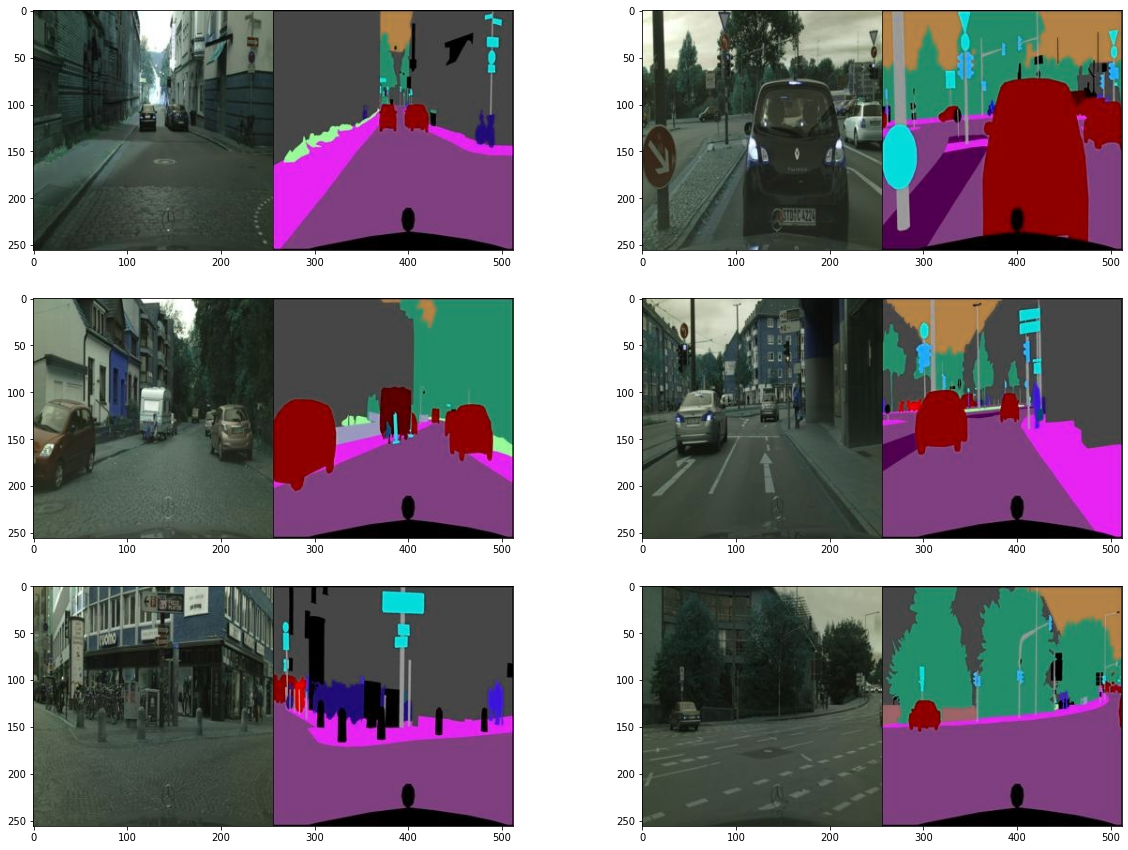

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

* 실제 배경과 segmentation 이미지가 같이 있습니다.
* 크기를 알아보겠습니다.

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* 하나의 이미지가 (256, 512) 크기이므로 (256,256)으로 나눠서 사용하겠습니다.

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    ground_truth = img[:, :w, :] 
    ground_truth = tf.cast(ground_truth, tf.float32)
    segmentation = img[:, w:, :] 
    segmentation = tf.cast(segmentation, tf.float32)
    return normalize(ground_truth), normalize(segmentation)

(256, 256, 3)
(256, 256, 3)


2022-09-18 19:45:50.080524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-18 19:45:50.705231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


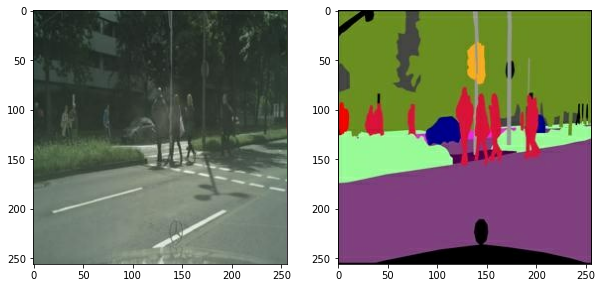

In [6]:
f = data_path + os.listdir(data_path)[1]
ground_truth, segmentation = load_img(f)

print(ground_truth.shape)
print(segmentation.shape)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(ground_truth))
plt.subplot(1,2,2); plt.imshow(denormalize(segmentation))

## Augmentation 적용

In [7]:
from tensorflow import image

@tf.function()
def apply_augmentation(ground_truth, segmentation):
    stacked = tf.concat([ground_truth, segmentation], axis=-1)
    
    out = image.random_crop(stacked, size=[256, 256, 6])
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    return out[...,:3], out[...,3:]   

* 가로 또는 세로로 뒤집습니다.

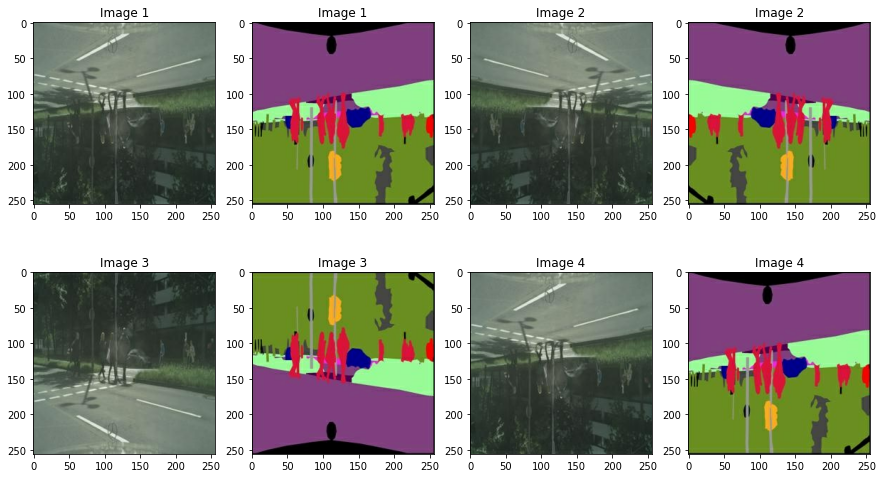

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 9, 2):
    augmented_ground_truth, augmented_segmentation = apply_augmentation(ground_truth, segmentation)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_ground_truth)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_segmentation)); plt.title(f"Image {img_n}")
    img_n += 1

* 가로, 세로로 잘 뒤집어진채로 나옵니다.
* 학습데이터에 적용해봅시다.
* 해당 위치의 이미지를 불러와서 Augmentation까지 적용하는 함수 입니다.

In [9]:
from tensorflow import data

def get_train(img_path):
    ground_truth, segmentation = load_img(img_path)
    ground_truth, segmentation = apply_augmentation(ground_truth, segmentation)
    return ground_truth, segmentation

* train 폴더에 있는 그림들에 적용합니다.
* 적용한 그림들 중에서 샘플을 가져와서 출력합니다.

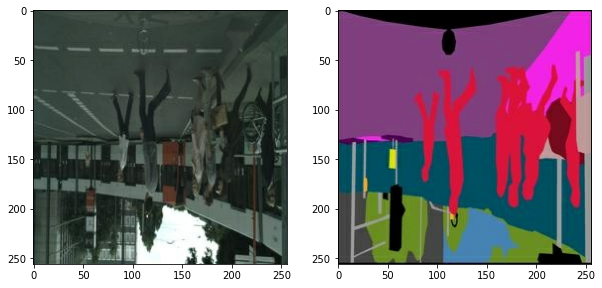

In [10]:
train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
ground_truth, segmentation = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(ground_truth[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(segmentation[0].astype(np.uint8))

## U-NET Generator 구성

* 기존의 Encode block, Decode block

In [11]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

* U-Net 구현

In [12]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [13]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

## Discriminator 구현

In [14]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [15]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_15 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [16]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [17]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

## 학습하기

* losses 와 optimizers 를 선언합니다.

In [18]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [19]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [20]:
@tf.function
def train_step(ground_truth, real_segmentation):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_segmentation = generator(ground_truth, training=True)
        # Discriminator 예측
        fake_disc = discriminator(ground_truth, fake_segmentation, training=True)
        real_disc = discriminator(ground_truth, real_segmentation, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_segmentation, real_segmentation, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

* EPOCHS를 10으로 잡습니다.

In [21]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (ground_truth, segmentation) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(ground_truth, segmentation)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

2022-09-18 19:45:58.399680: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


EPOCH[1] - STEP[10]                     
Generator_loss:0.9620                     
L1_loss:0.3187                     
Discriminator_loss:1.1682

EPOCH[1] - STEP[20]                     
Generator_loss:1.2173                     
L1_loss:0.2801                     
Discriminator_loss:0.9038

EPOCH[1] - STEP[30]                     
Generator_loss:1.5857                     
L1_loss:0.1989                     
Discriminator_loss:0.6220

EPOCH[1] - STEP[40]                     
Generator_loss:1.9117                     
L1_loss:0.2253                     
Discriminator_loss:0.6078

EPOCH[1] - STEP[50]                     
Generator_loss:2.0315                     
L1_loss:0.1920                     
Discriminator_loss:0.6530

EPOCH[1] - STEP[60]                     
Generator_loss:2.4438                     
L1_loss:0.2105                     
Discriminator_loss:0.3952

EPOCH[1] - STEP[70]                     
Generator_loss:1.9528                     
L1_loss:0.2432                    

## 테스트 하기

* test 샘플 확인

number of val examples : 5


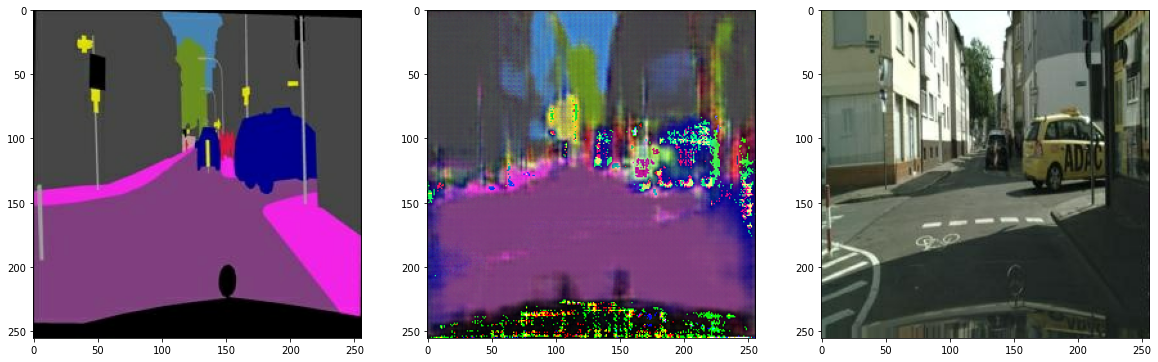

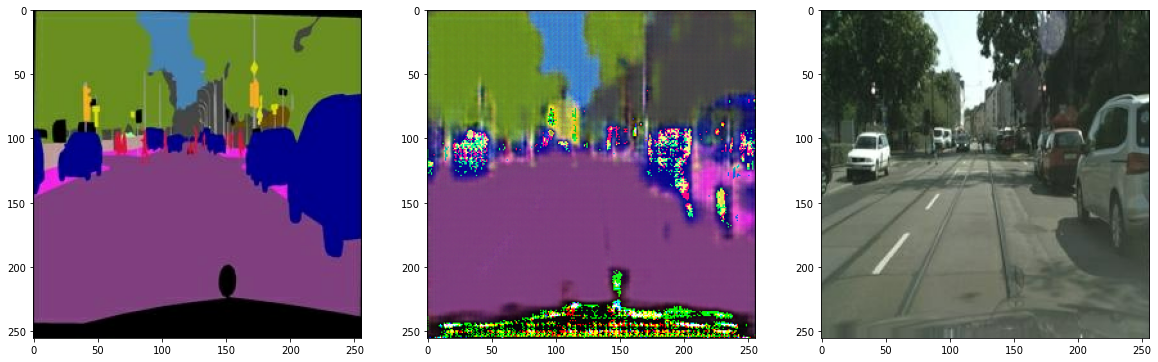

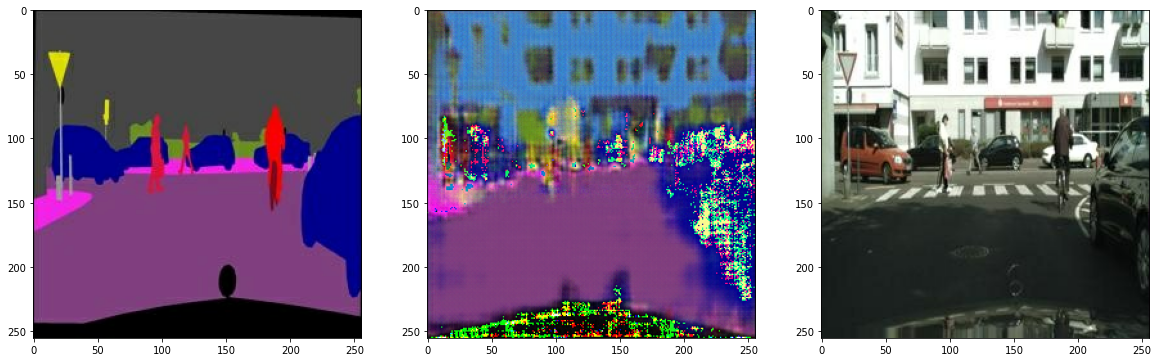

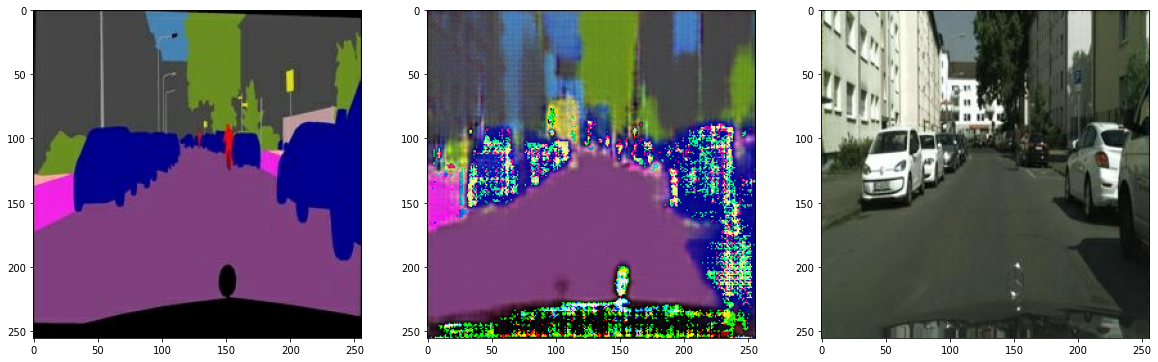

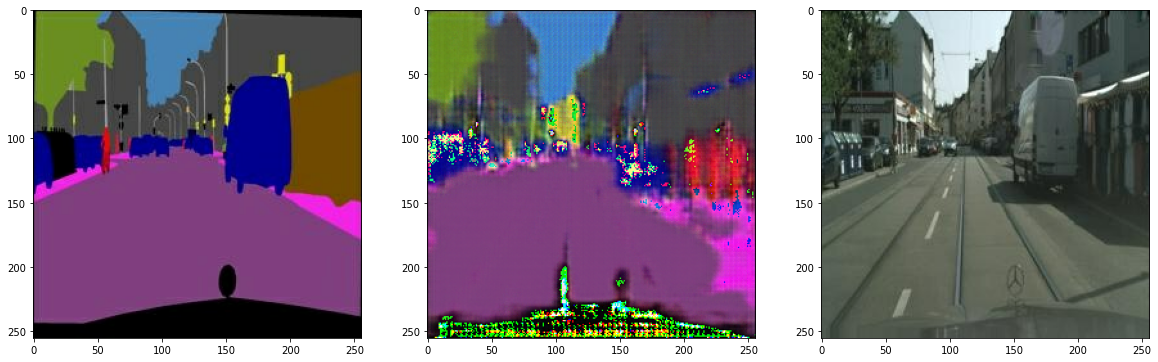

In [22]:
val_path = 'data/val/'
print("number of val examples :", len(os.listdir(val_path)))

for i in range(5):
    test = val_path + os.listdir(val_path)[i]
    val_ground_truth, val_segmentation = load_img(test)
    
    pred = generator(tf.expand_dims(val_ground_truth, 0))
    pred = denormalize(pred)
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(val_segmentation))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(val_ground_truth))
    plt.show()

* 확실히 10 epochs 만 한 만큼 좋은 결과를 얻지는 못했습니다.
* epochs를 증가시켜보겠습니다.

In [23]:
EPOCHS = 30

generator2 = UNetGenerator()
discriminator2 = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (ground_truth, segmentation) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(ground_truth, segmentation)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.4653                     
L1_loss:0.1792                     
Discriminator_loss:1.4601

EPOCH[1] - STEP[20]                     
Generator_loss:0.8540                     
L1_loss:0.1108                     
Discriminator_loss:1.2798

EPOCH[1] - STEP[30]                     
Generator_loss:1.8650                     
L1_loss:0.1303                     
Discriminator_loss:0.5940

EPOCH[1] - STEP[40]                     
Generator_loss:1.8708                     
L1_loss:0.1359                     
Discriminator_loss:0.3511

EPOCH[1] - STEP[50]                     
Generator_loss:0.9415                     
L1_loss:0.1412                     
Discriminator_loss:0.8205

EPOCH[1] - STEP[60]                     
Generator_loss:1.4244                     
L1_loss:0.1408                     
Discriminator_loss:0.4343

EPOCH[1] - STEP[70]                     
Generator_loss:2.0878                     
L1_loss:0.1648                    

* 출력해보기

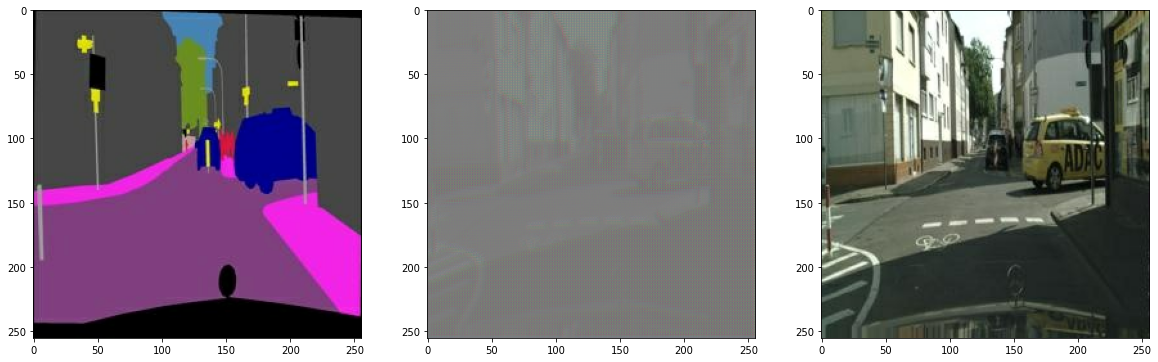

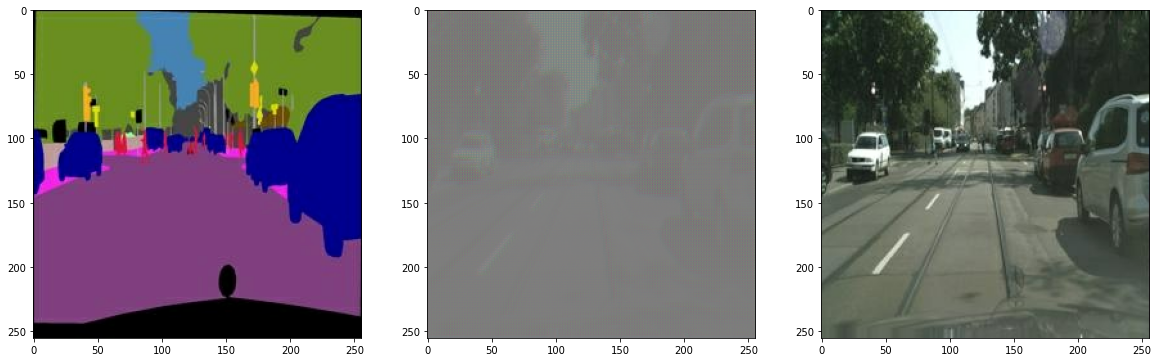

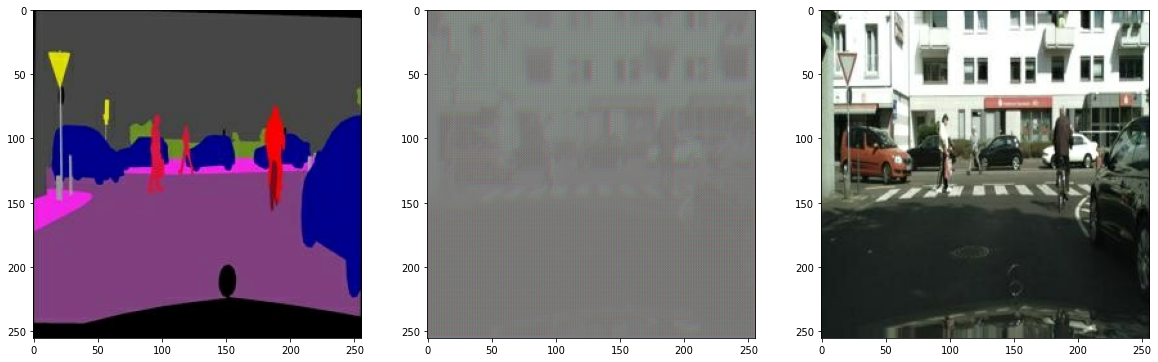

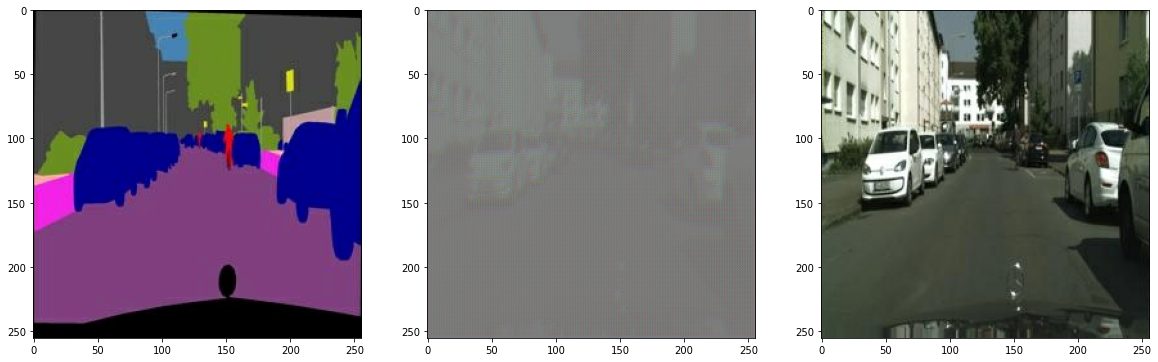

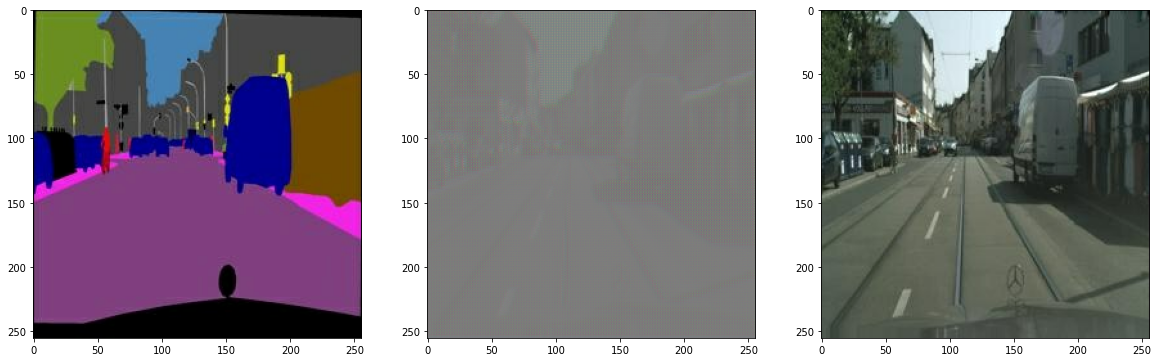

In [24]:
for i in range(5):
    test = val_path + os.listdir(val_path)[i]
    val_ground_truth2, val_segmentation2 = load_img(test)
    
    pred2 = generator2(tf.expand_dims(val_ground_truth2, 0))
    pred2 = denormalize(pred2)
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(val_segmentation2))
    plt.subplot(1,3,2); plt.imshow(pred2[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(val_ground_truth2))
    plt.show()

* 확실히 EPOCH를 늘려주니 더 나은 품질이 되었습니다.

## 회고

* 이번 프로젝트에서 어려웠던 점
    - U-Net의 이론적으로 이해하는 법
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된 점
    - U-Net을 적용한 것과 안 적용한 것의 차이
  * 아직 모호한 점
    - 높은 EPOCHS로 만든 가중치를를 저장해서 사용하고 싶은데 방법을 모르겠습니다.
* 루브릭 평가를 맞추기 위해 시도한 점
    - Augmentation 중 하나인 가로, 세로 반전을 사용하였다.
    - EPOCH 별 손실을 출력하였습니다.
    - 10 EPOCH와 30EPOCH의 예측 이미지를 구해서 비교해보았습니다.
